# Don't Overfit! II A Fistful of Samples
- [コンペのページ](https://www.kaggle.com/c/dont-overfit-ii/data)
- 参考ノートブック
    - [How to not overfit](https://www.kaggle.com/artgor/how-to-not-overfit)
    - [Dealing with very small datasets](https://www.kaggle.com/rafjaa/dealing-with-very-small-datasets)
- その他参考
    - [SHapley Additive exPlanationsで機械学習モデルを解釈する](https://speakerdeck.com/dropout009/shapley-additive-explanationsdeji-jie-xue-xi-moderuwojie-shi-suru)
- notebook 実行は 2020-10-28 近辺での Google Colab 前提
    - ライブラリのバージョンの整合性の問題

## 概要

### Overview
- 以前連続変数に関する 20,000x200 行列を 250 サンプルで訓練するというコンペ（？）的なものがあったらしい：当然ふつうにやったらオーバーフィットする。
- これの続編。

### Evaluation
- AUCROC を評価する

## ノートブック How to not overfit から
- [How to not overfit](https://www.kaggle.com/artgor/how-to-not-overfit)
- sklearn まわりでライブラリのバージョン問題があり、ワーニングが出ている
- 何となくは動く
- Google Colab との相性なのか、一部画像が出ない（ので必要に応じて元の notebook を見るかもしれない）

### 一般的な話
- コンペでは 300 列あつ 250 個のサンプルに対して 2 値分類する。
- テストデータは 79 倍の 19750 個ある。
- オーバーフィットなしに予測したい。
- このカーネルでやること
    - 特徴量の EDA とそれに対する感覚を養う
        - EDA（Exploratory Data Analysis, 探索的データ解析）
    - 最も影響がある特徴量に対する permutation importance を使う
    - いろいろなモデルを比較する: bayer classification, linear models, tree based models
    - eli5 や shap から最高の特徴量を選ぶことを含む特徴量選択に関していろいろな手法を使う
    - モデルに対するハイパーパラメータの最適化
    - 特徴量生成
    - その他

![](https://cdn-images-1.medium.com/max/1600/1*vuZxFMi5fODz2OEcpG-S1g.png)


### 目次

* [1 Data exploration](#de)
* [2 Basic modelling](#bm)
* [3 ELI5](#eli5)
* [3.1 ELI5 and permutation importance](#eli5p)
* [4 SHAP](#shap)
* [5 Mlextend SequentialFeatureSelector](#mlextend)
* [6 Modelling](#model)
* [7 Polynomial features](#poly)
* [8 Adding statistics](#stats)
* [9 Adding distance features](#dist)
* [10 Sklearn feature selection](#select)
* [11 GLM](#glm)
* [12 Selected top_features + statistics](#selected)

### 準備

#### ライブラリインストール

In [ ]:
!pip install eli5 shap catboost joblib

     |████████████████████████████████| 112kB 2.7MB/s 
     |████████████████████████████████| 327kB 10.7MB/s 
     |████████████████████████████████| 66.2MB 61kB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456473 sha256=b4b99eecead77a854714b69eec8ad8ff5fb86c173153c58e9fcf370c8306525f
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


#### ライブラリ読み込み

In [ ]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
import json
import ast
import time
from sklearn import linear_model
import eli5
from eli5.sklearn import PermutationImportance
import shap

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may

#### データ読み込み

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape

(250, 302)

<a id="de"></a>
### データ探索

In [ ]:
train.head()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,-0.443,-0.338,0.416,-2.177,-0.326,0.340,1.174,-0.245,-1.070,-0.336,-0.502,0.403,-0.605,-0.280,-1.618,0.878,-0.272,0.870,2.171,-0.214,0.477,-2.092,0.835,0.621,-2.810,1.029,-0.736,0.582,-0.079,0.493,1.359,-0.177,0.406,-0.163,1.341,0.754,0.491,-1.560,-0.520,0.766,0.216,-0.510,0.101,-0.602,-0.721,-0.545,1.564,2.003,-1.940,1.285,-0.987,-1.370,1.373,-0.495,0.113,-0.523,0.053,-0.888,0.249,0.687,1.363,0.169,-1.122,1.209,0.891,0.866,0.847,-1.110,1.224,-1.302,-1.647,-0.091,0.255,0.730,-0.380,0.294,-0.725,0.844,1.002,-1.267,-0.043,1.158,0.779,-0.733,-0.501,1.841,1.459,0.847,1.926,-0.316,0.044,-0.294,0.120,-1.050,0.730,-1.001,-0.321,0.407,0.469,0.445,1.632,0.273,1.557,1.196,-0.548,-0.275,0.179,0.584,-1.873,0.928,0.720,0.885,0.044,-1.131,-1.576,0.616,1.957,-0.518,1.494,1.573,-0.484,0.590,-0.387,0.388,-1.032,-0.841,0.288,-0.230,-2.714,-0.473,0.476,-1.352,-0.922,0.329,-0.558,0.787,-1.043,-0.130,0.517,2.445,0.847,-0.636,-0.324,0.753,0.058,-1.461,-0.820,-0.076,1.127,-0.496,1.020,0.279,0.262,-0.277,-0.166,-0.089,-1.696,-0.598,-0.710,-0.431,0.355,0.966,-1.150,-0.156,0.393,-0.117,0.444,0.948,-0.608,-0.106,-0.491,-0.608,1.565,1.013,-1.391,0.807,-0.607,-0.856,1.230,0.124,-0.336,1.758,-1.649,-1.429,-1.322,-1.501,2.125,-0.572,1.178,-1.451,-0.374,2.386,1.883,0.758,0.295,1.261,-0.837,0.140,-0.183,0.756,0.616,1.371,0.820,-0.702,-1.266,0.496,-0.669,-0.325,-0.170,0.147,-1.134,0.077,1.271,-0.087,-1.431,1.640,0.694,0.949,-2.400,0.657,-0.431,0.124,-0.335,-2.820,0.573,-0.755,3.798,-0.001,0.998,-0.543,1.018,0.883,-1.037,0.513,0.694,0.856,-0.523,0.596,0.971,0.279,2.684,-0.057,-1.754,0.297,-2.196,0.798,-0.533,-0.661,0.564,-2.400,0.945,-0.971,0.055,1.107,-0.848,-1.781,0.254,-0.515,0.234,0.296,-1.774,2.032,-0.442,-0.116,1.393,-0.494,-0.179,1.874,1.463,-1.397,0.284,0.336,0.551,0.557,-0.522,-0.503,-0.541,1.393,0.506,-1.420,-0.123,-1.833,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,0.557,1.202,0.542,0.424,-1.572,-0.968,-1.483,0.564,0.047,-0.324,-1.490,0.179,-0.524,0.250,2.462,0.029,-1.399,-2.370,-1.505,-1.294,0.106,-0.145,0.235,-1.045,1.335,1.254,-0.811,1.812,0.181,-0.020,1.125,0.279,-0.682,1.161,1.194,0.243,1.179,1.338,-1.000,-0.362,-0.605,1.917,-1.157,0.394,-0.482,1.591,0.106,-0.959,0.600,-1.147,-1.064,3.080,1.057,0.947,-1.125,1.288,-0.171,1.124,-0.454,0.698,-0.028,2.208,0.014,0.872,2.286,-0.822,0.416,1.486,-0.331,-0.993,-0.071,0.543,-0.096,0.041,0.138,1.110,0.692,1.407,-0.234,-1.899,-0.131,0.934,0.802,-1.041,2.004,1.424,0.423,-0.352,-0.656,-0.053,1.036,-1.228,-0.854,-0.748,1.180,0.575,-1.472,-1.215,-0.889,0.004,-0.145,-0.933,-0.713,0.869,0.539,-0.911,-0.638,0.895,-1.896,-0.604,0.312,1.883,-0.292,-0.849,-0.453,0.894,0.339,2.095,0.336,1.290,0.057,-0.159,0.539,0.675,-1.015,-0.304,-1.301,-0.614,-1.176,0.117,0.075,-0.088,1.888,-0.119,0.434,0.135,1.779,0.5

#### target の値の確認

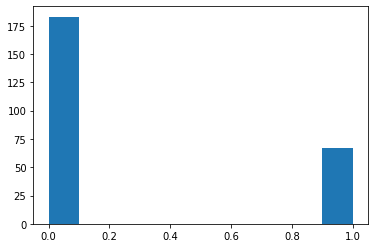

In [ ]:
plt.hist(train["target"])
plt.show()

##### 結果
- ターゲットは 2 値で 0, 1

#### 全列の標準偏差

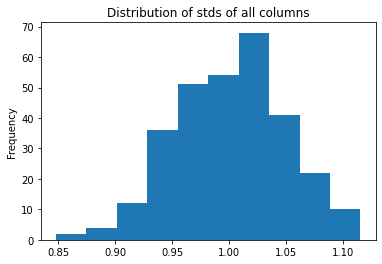

In [ ]:
train[train.columns[2:]].std().plot(kind='hist');
plt.title('Distribution of stds of all columns');

#### 全列の平均

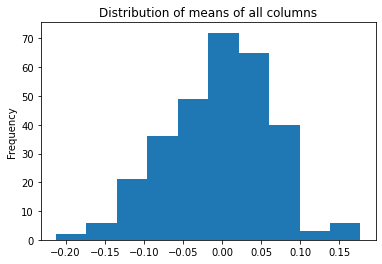

In [ ]:
train[train.columns[2:]].mean().plot(kind='hist');
plt.title('Distribution of means of all columns');

#### 欠損値の確認
- 欠損値なし

In [ ]:
# we have no missing values
train.isnull().any().any()

False

#### 最初の 28 列の分布

Distributions of first 28 columns


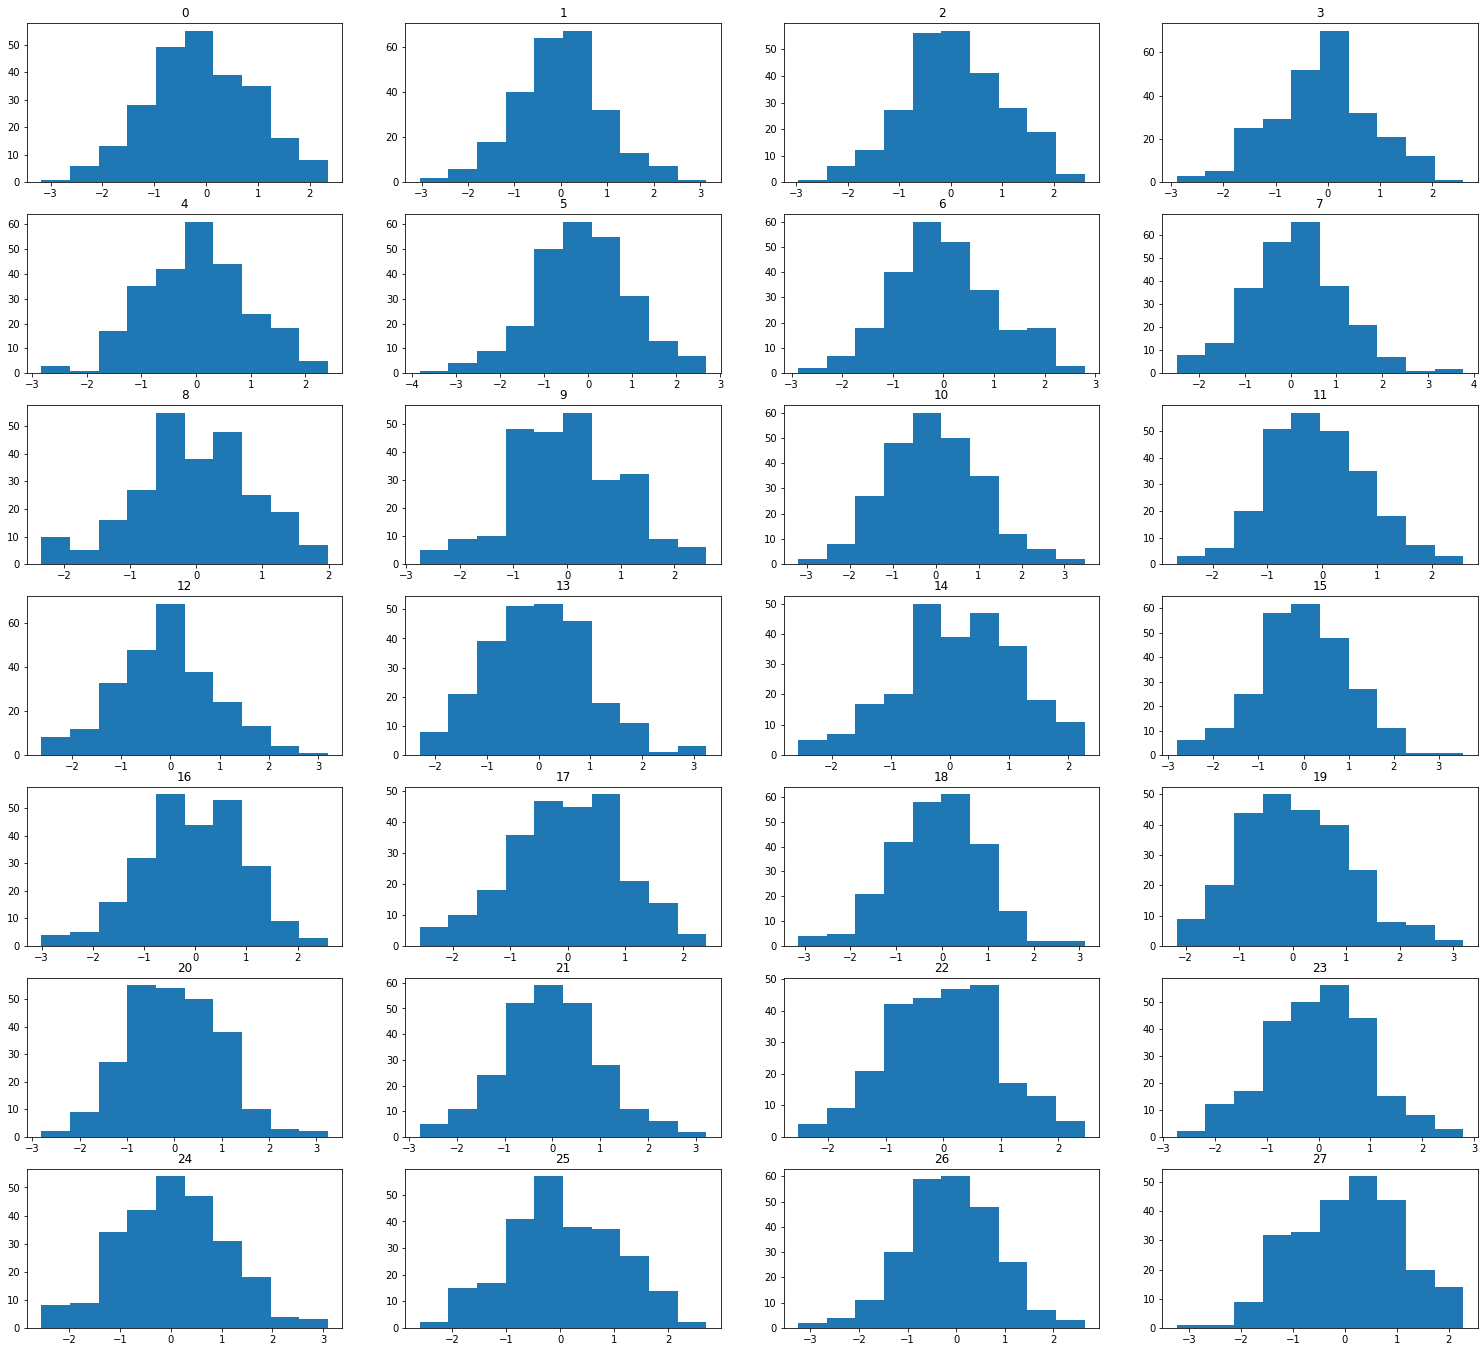

In [ ]:
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(train[col])
    plt.title(col)

#### value_counts() でデータの値の頻度を計算

In [ ]:
train['target'].value_counts()

0.0    183
1.0     67
Name: target, dtype: int64

#### まとめ
- ターゲットは2値で不均衡がある：サンプルの 7 割が 0 クラス
- 列の値は多かれ少なかれ同じような値を持つ
- 列の標準偏差は $1 \pm 0.1$
- 列の平均は $\pm 0.15$

### 相関を見る

In [ ]:
corrs = train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
90892,219,279,0.238512
90893,279,219,0.238512
90894,23,20,0.246984
90895,20,23,0.246984
90896,146,228,0.258447
90897,228,146,0.258447
90898,6,39,0.267727
90899,39,6,0.267727
90900,127,target,0.337540
90901,target,127,0.337540


#### メモ
- 特徴量の間の相関は 0.3 以下
- ターゲットと最も相関している特徴量の相関は 0.37
- 落とせてかつ相関が強い特徴量はない
- 一方、目的変数との相関がほぼなく、落とせる特徴量はいくつかある。

<a id="bm"></a>
### 基本的なモデリング

#### 訓練データ・テストデータの読み込み

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
n_fold = 20
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### モデルを訓練する関数
- `model_type` でいろいろなモデルを選べるようになっている

In [ ]:
def train_model(X, X_test, y, params, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        # print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=2000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_tr.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_tr.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000,  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
            
            
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

#### `logreg` （LogisticRegression）で試してみる

In [ ]:
# A lot of people are using logreg currently, let's try
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7431, std: 0.1357.


#### パラメータを調整
- 少し時間がかかる

In [ ]:
# A lot of people are using logreg currently, let's try
cat_params = {'learning_rate': 0.02,
              'depth': 5,
              'l2_leaf_reg': 10,
              'bootstrap_type': 'Bernoulli',
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 50,
              'random_seed': 11,
              'allow_writing_files': False}
oof_lr, prediction_lr, scores = train_model(X_train, X_test, y_train, params=cat_params, model_type='cat')

CV mean score: 0.5083, std: 0.0363.


#### catboost

In [ ]:
model = CatBoostClassifier(iterations=400,  eval_metric='AUC', **cat_params)
model.fit(X_train, y_train, cat_features=[], use_best_model=True, verbose=200)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	total: 51.1ms	remaining: 20.4s
200:	total: 9.57s	remaining: 9.47s
399:	total: 19.2s	remaining: 0us


In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr_repeated, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)

CV mean score: 0.7071, std: 0.1428.


##### 結果提出メモ
- `prediction_lr` を提出するとリーダーボードで 0.847

<a id="eli5"></a>
### ELI5
- ELI5 は機械学習モデルに対する説明を与えてくれるパッケージ（どういうこと？）
- 線型モデルだけでなく、ランダムフォレストや lightbgm のようなツリーベースのモデルでも大丈夫

In [ ]:
eli5.show_weights(model, top=50)

Weight?,Feature
+0.568,x127
+0.346,x18
+0.162,x66
+0.123,x241
+0.090,x32
+0.090,x260
+0.077,x93
+0.055,x178
+0.038,x213
+0.033,x208


In [ ]:
(model.coef_ != 0).sum()

35

#### 分析結果
- いくつかの特徴量が特に強い正の相関を持つ
- 実際 ELI5 によると 32 個の特徴量だけが重要
- モデル自体は34の非ゼロの特徴量を持ち、ELI5は2つ特徴量を落としただけ。
- 32だけ使って試してみよう

In [ ]:
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i]
X_train = train[top_features]
X_test = test[top_features]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7456, std: 0.1317.


#### 再計算結果
- 0.7226 から 0.7486 になった。
- リーダーボードでは 0.845 でスコアが落ちた
- 別のことを試してみよう

<a id="eli5p"></a>
#### パフォーマンスの重要性
- eli5 には他の使い方もある
- 次のようにしてパフォーマンスをみる
    - モデルをフィットする
    - バリデーションデータの1列をランダムにシャッフルして、スコアを計算する
    - もしスコアが強く下がるならその特徴量は大事なはず。
- このアプローチについては[このページ](https://www.kaggle.com/dansbecker/permutation-importance)参照。

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, top=50)

Weight,Feature
0.0912 ± 0.0415,x0
0.0368 ± 0.0352,x1
0.0328 ± 0.0185,x25
0.0272 ± 0.0199,x33
0.0200 ± 0.0168,x30
0.0200 ± 0.0182,x3
0.0176 ± 0.0082,x28
0.0168 ± 0.0093,x20
0.0120 ± 0.0299,x26
0.0064 ± 0.0120,x31


In [ ]:
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(perm).feature if 'BIAS' not in i]
X_train = train[top_features]
X_test = test[top_features]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr1, prediction_lr1, _ = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.5640, std: 0.1368.


#### 分析結果
- パフォーマンスの重要性に応じて列を選んだらスコアは大きく悪化
- この場合はうまく使えないようだ

<a id="shap"></a>
### SHAP
- SHAP も面白いツール
- モデルの多様性に対する説明を与える

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7431, std: 0.1357.


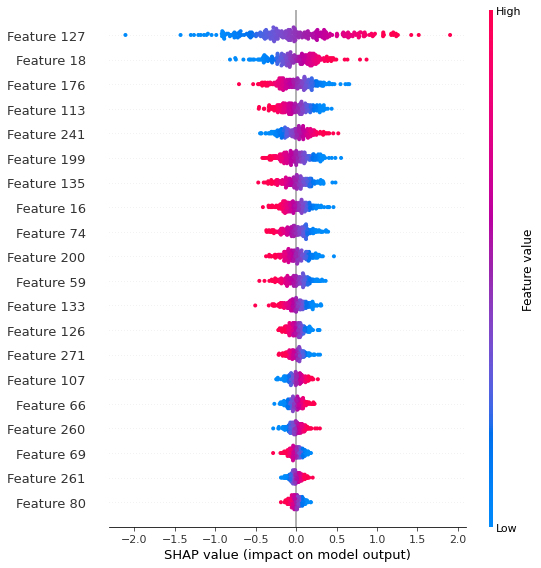

In [ ]:
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

#### 結果
- はじめてみるとこのプロットの解釈は難しいだろう
    - 特徴量が予測にどれだけインパクトを与えるかを教えてくれている
- 例えば feature 33 で低い値はモデル予測への否定的な影響を持つ（0 はよりありえる）。高い値は正の影響を与える。
- Feature 217 は逆の効果を持つ
- 特徴量を手動で与える必要があって面倒：ライブラリを使おう

<a id="mlextend"></a>
### Mlextend SequentialFeatureSelector

In [ ]:
sfs1 = SFS(model, 
           k_features=(10, 15), 
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='roc_auc',
           cv=folds,
          n_jobs=-1)

sfs1 = sfs1.fit(X_train, y_train)

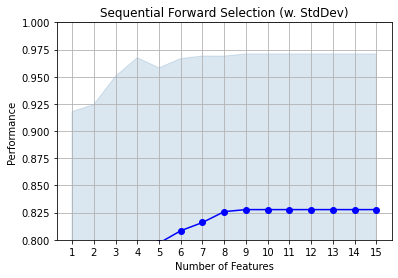

In [ ]:
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [ ]:
top_features = list(sfs1.k_feature_names_)
X_train = train[top_features]
X_test = test[top_features]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7301, std: 0.1561.


#### 結果
- リーダーボードでは 0.811：オーバーフィットしている
- 特徴量選択は最良の選択肢ではない
- いろいろなモデルを作ってみよう

 And this gives 0.811 on leaderboard. Overfitting! It seems that feature selection isn't the best approach. Let's try building various models!

<a id="model"></a>
### モデリング

#### `linear_model.LogisticRegression(solver='liblinear', max_iter=1000)`

##### パラメータその1

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
lr = linear_model.LogisticRegression(solver='liblinear', max_iter=1000)

parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2'],
                  'C' : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                  'solver': ['newton-cg', 'sag', 'lbfgs']
                 }

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=folds, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7075925925925926
Best parameters: {'C': 10.0, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'}


##### パラメータその2

In [ ]:
lr = linear_model.LogisticRegression(solver='liblinear', max_iter=10000)

parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2', 'l1'],
                  'C' : [0.001, 0.01, 0.08, 0.1, 0.15, 1.0, 10.0, 100.0],
                 }

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=folds, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7830555555555557
Best parameters: {'C': 0.1, 'class_weight': None, 'penalty': 'l1'}


In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7431, std: 0.1357.


#### パラメータについて
- logreg に対するパラメータが最適化された
- ほかのモデルを試してみよう

So, parameters for logreg are optimal, let's try other models

#### naive_bayes, `GaussianNB()`

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
oof_gnb, prediction_gnb, scores_gnb = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=gnb)

CV mean score: 0.5462, std: 0.0910.


#### `AdaBoostClassifier`

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()

parameter_grid = {'n_estimators': [5, 10, 20, 50, 100],
                  'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0]
                 }

grid_search = GridSearchCV(abc, param_grid=parameter_grid, cv=folds, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.6804629629629629
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}


In [ ]:
abc = AdaBoostClassifier(**grid_search.best_params_)
oof_abc, prediction_abc, scores_abc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=abc)

CV mean score: 0.5625, std: 0.1363.


#### ExtraTreesClassifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()

parameter_grid = {'n_estimators': [10, 50, 100, 1000],
                  'max_depth': [None, 3, 5, 15]
                 }

grid_search = GridSearchCV(etc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
etc = ExtraTreesClassifier(**grid_search.best_params_)
oof_etc, prediction_etc, scores_etc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=etc)

Best score: 0.7019444444444445
Best parameters: {'max_depth': 15, 'n_estimators': 1000}
CV mean score: 0.5000, std: 0.0000.


#### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 50, 100, 1000],
                  'max_depth': [None, 3, 5, 15]
                 }

grid_search = GridSearchCV(rfc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
rfc = RandomForestClassifier(**grid_search.best_params_)
oof_rfc, prediction_rfc, scores_rfc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=rfc)

Best score: 0.6567592592592592
Best parameters: {'max_depth': 15, 'n_estimators': 1000}
CV mean score: 0.5000, std: 0.0000.


#### GaussianProcessClassifier

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
gpc = GaussianProcessClassifier()
oof_gpc, prediction_gpc, scores_gpc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=gpc)

CV mean score: 0.5504, std: 0.1508.


#### SVC

In [ ]:
from sklearn.svm import SVC
svc = SVC(probability=True, gamma='scale')

parameter_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                  'kernel': ['linear', 'poly', 'rbf'],
                 }

grid_search = GridSearchCV(svc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
svc = SVC(probability=True, gamma='scale', **grid_search.best_params_)
oof_svc, prediction_svc, scores_svc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=svc)

Best score: 0.6980555555555554
Best parameters: {'C': 10.0, 'kernel': 'rbf'}
CV mean score: 0.4975, std: 0.0444.


#### KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()

parameter_grid = {'n_neighbors': [2, 3, 5, 10, 20],
                  'weights': ['uniform', 'distance'],
                  'leaf_size': [5, 10, 30]
                 }

grid_search = GridSearchCV(knc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
knc = KNeighborsClassifier(**grid_search.best_params_)
oof_knc, prediction_knc, scores_knc = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=knc)

Best score: 0.5949074074074073
Best parameters: {'leaf_size': 5, 'n_neighbors': 20, 'weights': 'distance'}
CV mean score: 0.5000, std: 0.0000.


#### BernoulliNB

In [ ]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

parameter_grid = {'alpha': [0.0001, 1, 2, 10]
                 }

grid_search = GridSearchCV(bnb, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
bnb = BernoulliNB(**grid_search.best_params_)
oof_bnb, prediction_bnb, scores_bnb = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=bnb)

Best score: 0.5453703703703704
Best parameters: {'alpha': 2}
CV mean score: 0.4792, std: 0.1370.


#### SGDClassifier

In [ ]:
sgd = linear_model.SGDClassifier(eta0=1, max_iter=1000, tol=0.0001)

parameter_grid = {'loss': ['log', 'modified_huber'],
                  'penalty': ['l1', 'l2', 'elasticnet'],
                  'alpha': [0.001, 0.01],
                  'l1_ratio': [0, 0.15, 0.5, 1.0],
                  'learning_rate': ['optimal', 'invscaling', 'adaptive']
                 }

grid_search = GridSearchCV(sgd, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
sgd = linear_model.SGDClassifier(eta0=1, tol=0.0001, **grid_search.best_params_)
oof_sgd, prediction_sgd, scores_sgd = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=sgd)

Best score: 0.7520370370370371
Best parameters: {'alpha': 0.01, 'l1_ratio': 1.0, 'learning_rate': 'adaptive', 'loss': 'log', 'penalty': 'elasticnet'}
CV mean score: 0.6522, std: 0.1687.


#### スコアの図示

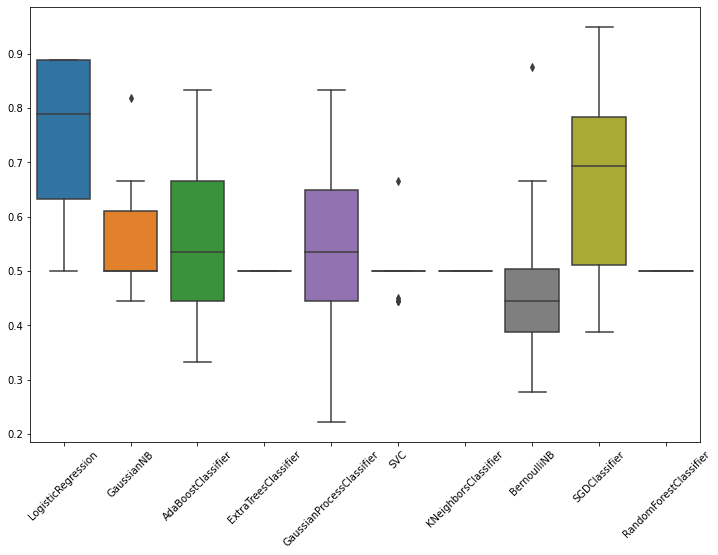

In [ ]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame({'LogisticRegression': scores})
scores_df['GaussianNB'] = scores_gnb
scores_df['AdaBoostClassifier'] = scores_abc
scores_df['ExtraTreesClassifier'] = scores_etc
scores_df['GaussianProcessClassifier'] = scores_gpc
scores_df['SVC'] = scores_svc
scores_df['KNeighborsClassifier'] = scores_knc
scores_df['BernoulliNB'] = scores_bnb
scores_df['SGDClassifier'] = scores_sgd
scores_df['RandomForestClassifier'] = scores_rfc

sns.boxplot(data=scores_df);
plt.xticks(rotation=45);

#### グラフを眺めて
- logreg はほかのモデルよりもいい結果になった
- SVC だけが比肩する結果
- ほかのモデルはオーバーフィットするかこの小さなデータセットではうまく動かないように見える
- これらを混ぜて提出してみよう

#### 再実験

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7431, std: 0.1357.


In [ ]:
# submission = pd.read_csv('../input/sample_submission.csv')
# submission['target'] = (prediction_lr + prediction_svc) / 2
# submission.to_csv('submission.csv', index=False)

# submission.head()

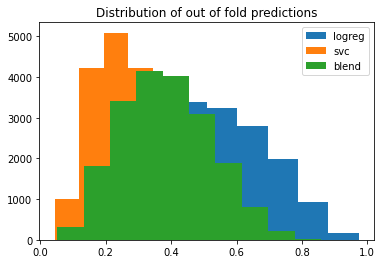

In [ ]:
plt.hist(prediction_lr, label='logreg');
plt.hist(prediction_svc, label='svc');
plt.hist((prediction_lr + prediction_svc) / 2, label='blend');
plt.title('Distribution of out of fold predictions');
plt.legend();

#### ブレンド結果
- リーダーボード上 0.831 で特によくはない
- いくつか特徴量を作ってみよう

Sadly blend gives 0.831 on LB. Again no luck.

Let's try generating some features!

<a id="poly"></a>
### 多項式的特徴量
- 訳はあっているか？
- Polynomial Features

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)

X_train = train.drop(['id', 'target'], axis=1)
X_test = test.drop(['id'], axis=1)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

#### 記録
- 多項式的特徴量（polynomial features）の数は ~45k もある
- それらのうちのいくつかを選ぶ方法が必要
- 目標変数との相関を見てみよう

The number of polynomial features is ~45k which is too much. We need some way to select some of them. Let's try use correlations with target.

In [ ]:
cor = pd.DataFrame(X_train_poly).corrwith(y_train)

In [ ]:
sc = []
for i in range(10, 510, 5):
    top_corr_cols = list(cor.abs().sort_values().tail(i).reset_index()['index'].values)
    X_train_poly1 = X_train_poly[:, top_corr_cols]
    X_test_poly1 = X_test_poly[:, top_corr_cols]
    oof_lr_poly, prediction_lr_poly, scores = train_model(X_train_poly1, X_test_poly1, y_train, params=None, model_type='sklearn', model=model)
    sc.append(scores)

CV mean score: 0.7686, std: 0.1499.
CV mean score: 0.7950, std: 0.1621.
CV mean score: 0.8467, std: 0.1206.
CV mean score: 0.8407, std: 0.1277.
CV mean score: 0.8485, std: 0.1255.
CV mean score: 0.8297, std: 0.1258.
CV mean score: 0.8258, std: 0.1212.
CV mean score: 0.8354, std: 0.1236.
CV mean score: 0.8710, std: 0.1107.
CV mean score: 0.8493, std: 0.1383.
CV mean score: 0.8678, std: 0.1018.
CV mean score: 0.8657, std: 0.1064.
CV mean score: 0.8546, std: 0.1063.
CV mean score: 0.8435, std: 0.1080.
CV mean score: 0.8518, std: 0.0954.
CV mean score: 0.8574, std: 0.0990.
CV mean score: 0.8579, std: 0.0889.
CV mean score: 0.8579, std: 0.0849.
CV mean score: 0.8551, std: 0.0870.
CV mean score: 0.8440, std: 0.1035.
CV mean score: 0.8360, std: 0.1191.
CV mean score: 0.8357, std: 0.1169.
CV mean score: 0.8294, std: 0.1244.
CV mean score: 0.8267, std: 0.1358.
CV mean score: 0.8322, std: 0.1098.
CV mean score: 0.8350, std: 0.0876.
CV mean score: 0.8285, std: 0.1011.
CV mean score: 0.8292, std: 

In [ ]:
data = [go.Scatter(
        x = list(range(10, 510, 5)),
        y = [np.round(np.mean(i), 4) for i in sc],
        name = 'CV scores'
    )]
layout = go.Layout(dict(title = "Top N poly features vs CV",
                  xaxis = dict(title = 'Top N features'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

#### 結果
- オーバーフィットしている
- 図が表示されないので元の ipynb を見てみよう

In [ ]:
top_corr_cols = list(cor.abs().sort_values().tail(300).reset_index()['index'].values)
X_train_poly1 = X_train_poly[:, top_corr_cols]
X_test_poly1 = X_test_poly[:, top_corr_cols]

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr_poly, prediction_lr_poly, scores = train_model(X_train_poly1, X_test_poly1, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7486, std: 0.1486.


In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = prediction_lr_poly
# submission.to_csv('submission_poly.csv', index=False)

submission.head()

,id,target
0,250,0.392740
1,251,0.398958
2,252,0.407719
3,253,0.281137
4,254,0.758019


#### 結果
- スコアは低下
- いい考えではなかった

Score became much lower. So this is also a bad idea

<a id="stats"></a>
### Adding statistics

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
X_test = test.drop(['id'], axis=1)
X_train['300'] = X_train.std(1)
X_test['300'] = X_test.std(1)
scaler = StandardScaler()
X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr_1, prediction_lr_1, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7403, std: 0.1355.


- 繰り返した KFold と比べてみよう

Let's compare with repeated KFold.

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
X_test = test.drop(['id'], axis=1)
X_train['300'] = X_train.std(1)
X_test['300'] = X_test.std(1)
scaler = StandardScaler()
X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr_1, prediction_lr_1_repeated, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)
submission = pd.read_csv('sample_submission.csv')
submission['target'] = prediction_lr_1_repeated
submission.to_csv('repeated_fold_features.csv', index=False)

submission.head()

CV mean score: 0.7069, std: 0.1432.


,id,target
0,250,15.005320
1,251,9.724994
2,252,11.444491
3,253,12.744453
4,254,14.222700


#### 結果
- CV は少し上がった

CV increased a bit!

<a id="dist"></a>
### Adding distance features

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
X_test = test.drop(['id'], axis=1)
main_cols = X_train.columns.tolist()

In [ ]:
neigh = NearestNeighbors(5, n_jobs=-1)
neigh.fit(X_train)

dists, _ = neigh.kneighbors(X_train, n_neighbors=5)
mean_dist = dists.mean(axis=1)
max_dist = dists.max(axis=1)
min_dist = dists.min(axis=1)

X_train['300'] = X_train.std(1)
X_train = np.hstack((X_train, mean_dist.reshape(-1, 1), max_dist.reshape(-1, 1), min_dist.reshape(-1, 1)))

test_dists, _ = neigh.kneighbors(X_test, n_neighbors=5)

test_mean_dist = test_dists.mean(axis=1)
test_max_dist = test_dists.max(axis=1)
test_min_dist = test_dists.min(axis=1)

X_test['300'] = X_test.std(1)
X_test = np.hstack((X_test, test_mean_dist.reshape(-1, 1), test_max_dist.reshape(-1, 1), test_min_dist.reshape(-1, 1)))

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr_2, prediction_lr_2, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)
submission['target'] = prediction_lr_2
submission.to_csv('nn_features.csv', index=False)

CV mean score: 0.6929, std: 0.1648.


In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = (prediction_lr_1 + prediction_lr_2) / 2
# submission.to_csv('blend.csv', index=False)

submission.head()

,id,target
0,250,0.741765
1,251,0.470430
2,252,0.530269
3,253,0.612137
4,254,0.700765


<a id="select"></a>
### Sklearn feature selection
- SKLearn は特徴量選択のためのメソッドをいくつか持っている
- 試してみよう

Sklearn has several methods to do feature selection. Let's try some of them!

In [ ]:
# baseline score
X_train = train.drop(['id', 'target'], axis=1)
X_test = test.drop(['id'], axis=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr_1, prediction_lr_1, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7431, std: 0.1357.


In [ ]:
scores_dict = {'f_classif': [], 'mutual_info_classif': []}
for i in range(5, 100, 5):
    s1 = SelectPercentile(f_classif, percentile=i)
    X_train1 = s1.fit_transform(X_train, y_train.values.astype(int))
    X_test1 = s1.transform(X_test)
    oof_lr_1, prediction_lr_1, scores = train_model(X_train1, X_test1, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['f_classif'].append(np.mean(scores))
    
    s2 = SelectPercentile(mutual_info_classif, percentile=i)
    X_train1 = s2.fit_transform(X_train, y_train.values.astype(int))
    X_test1 = s2.transform(X_test)
    oof_lr_1, prediction_lr_1, scores = train_model(X_train1, X_test1, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['mutual_info_classif'].append(np.mean(scores))

CV mean score: 0.7664, std: 0.1369.
CV mean score: 0.6518, std: 0.1585.
CV mean score: 0.7668, std: 0.1414.
CV mean score: 0.6794, std: 0.1476.
CV mean score: 0.7543, std: 0.1389.
CV mean score: 0.6964, std: 0.1410.
CV mean score: 0.7483, std: 0.1529.
CV mean score: 0.6815, std: 0.1222.
CV mean score: 0.7428, std: 0.1545.
CV mean score: 0.6753, std: 0.1235.
CV mean score: 0.7372, std: 0.1496.
CV mean score: 0.6701, std: 0.1269.
CV mean score: 0.7372, std: 0.1496.
CV mean score: 0.7051, std: 0.1385.
CV mean score: 0.7372, std: 0.1496.
CV mean score: 0.6815, std: 0.1362.
CV mean score: 0.7372, std: 0.1496.
CV mean score: 0.7083, std: 0.1197.
CV mean score: 0.7375, std: 0.1403.
CV mean score: 0.7017, std: 0.1185.
CV mean score: 0.7403, std: 0.1405.
CV mean score: 0.6883, std: 0.1668.
CV mean score: 0.7431, std: 0.1357.
CV mean score: 0.6883, std: 0.1668.
CV mean score: 0.7431, std: 0.1357.
CV mean score: 0.6971, std: 0.1434.
CV mean score: 0.7431, std: 0.1357.
CV mean score: 0.7153, std: 

In [ ]:
data = [go.Scatter(
        x = list(range(5, 100, 5)),
        y = scores_dict['f_classif'],
        name = 'CV scores f_classif'
    ), go.Scatter(
        x = list(range(5, 100, 5)),
        y = scores_dict['mutual_info_classif'],
        name = 'CV scores mutual_info_classif')]
layout = go.Layout(dict(title = "Top N features by percentile vs CV",
                  xaxis = dict(title = 'Top N features by percentile'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

#### 結果
- Google Colab 上ではまた画像が出ない

In [ ]:
scores_dict = {'f_classif': [], 'mutual_info_classif': []}
for i in range(10, 301, 10):
    s1 = SelectKBest(f_classif, k=i)
    X_train1 = s1.fit_transform(X_train, y_train.values.astype(int))
    X_test1 = s1.transform(X_test)
    oof_lr_1, prediction_lr_1, scores = train_model(X_train1, X_test1, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['f_classif'].append(np.mean(scores))
    
    s2 = SelectKBest(mutual_info_classif, k=i)
    X_train1 = s2.fit_transform(X_train, y_train.values.astype(int))
    X_test1 = s2.transform(X_test)
    oof_lr_1, prediction_lr_1, scores = train_model(X_train1, X_test1, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['mutual_info_classif'].append(np.mean(scores))

CV mean score: 0.7140, std: 0.1525.
CV mean score: 0.5990, std: 0.1642.
CV mean score: 0.7761, std: 0.1243.
CV mean score: 0.6317, std: 0.1835.
CV mean score: 0.7668, std: 0.1414.
CV mean score: 0.6981, std: 0.1388.
CV mean score: 0.7543, std: 0.1389.
CV mean score: 0.7046, std: 0.1402.
CV mean score: 0.7483, std: 0.1403.
CV mean score: 0.6762, std: 0.1478.
CV mean score: 0.7483, std: 0.1529.
CV mean score: 0.6679, std: 0.1501.
CV mean score: 0.7344, std: 0.1501.
CV mean score: 0.6760, std: 0.1313.
CV mean score: 0.7456, std: 0.1500.
CV mean score: 0.6674, std: 0.1294.
CV mean score: 0.7372, std: 0.1496.
CV mean score: 0.6701, std: 0.1269.
CV mean score: 0.7372, std: 0.1496.
CV mean score: 0.6906, std: 0.1421.
CV mean score: 0.7372, std: 0.1496.
CV mean score: 0.6850, std: 0.1440.
CV mean score: 0.7372, std: 0.1496.
CV mean score: 0.6811, std: 0.1388.
CV mean score: 0.7372, std: 0.1496.
CV mean score: 0.6706, std: 0.1286.
CV mean score: 0.7403, std: 0.1405.
CV mean score: 0.6989, std: 

In [ ]:
data = [go.Scatter(
        x = list(range(10, 301, 10)),
        y = scores_dict['f_classif'],
        name = 'CV scores f_classif'
    ), go.Scatter(
        x = list(range(10, 301, 10)),
        y = scores_dict['mutual_info_classif'],
        name = 'CV scores mutual_info_classif')]
layout = go.Layout(dict(title = "Top N features by SelectKBest vs CV",
                  xaxis = dict(title = 'Top N features by SelectKBest'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

#### 結果
- Google Colab 上で画像が出ない

In [ ]:
selector = SelectKBest(f_classif, k=60)
X_trainK = selector.fit_transform(X_train, y_train.values.astype(int))
X_testK = selector.transform(X_test)
oof_lr_1, prediction_lr_1, scores = train_model(X_trainK, X_testK, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7483, std: 0.1529.


In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = prediction_lr_1
# submission.to_csv('top_n_features.csv', index=False)

submission.head()

,id,target
0,250,0.759482
1,251,0.494026
2,252,0.573728
3,253,0.632188
4,254,0.703624


In [ ]:
scores_list = []
for i in range(10, 301, 5):
    s = RFE(model, i, step=1)
    X_train1 = s.fit_transform(X_train, y_train.values.astype(int))
    X_test1 = s.transform(X_test)
    oof_lr_1, prediction_lr_1, scores = train_model(X_train1, X_test1, y_train, params=None, model_type='sklearn', model=model)
    scores_list.append(np.mean(scores))

CV mean score: 0.7283, std: 0.1603.
CV mean score: 0.7725, std: 0.1339.
CV mean score: 0.7550, std: 0.1442.
CV mean score: 0.7599, std: 0.1383.
CV mean score: 0.7594, std: 0.1475.
CV mean score: 0.7567, std: 0.1385.
CV mean score: 0.7567, std: 0.1385.
CV mean score: 0.7567, std: 0.1385.
CV mean score: 0.7567, std: 0.1385.
CV mean score: 0.7567, std: 0.1385.
CV mean score: 0.7567, std: 0.1385.
CV mean score: 0.7567, std: 0.1385.
CV mean score: 0.7539, std: 0.1424.
CV mean score: 0.7539, std: 0.1424.
CV mean score: 0.7539, std: 0.1424.
CV mean score: 0.7400, std: 0.1511.
CV mean score: 0.7400, std: 0.1511.
CV mean score: 0.7400, std: 0.1511.
CV mean score: 0.7400, std: 0.1511.
CV mean score: 0.7483, std: 0.1386.
CV mean score: 0.7508, std: 0.1409.
CV mean score: 0.7508, std: 0.1409.
CV mean score: 0.7508, std: 0.1409.
CV mean score: 0.7508, std: 0.1409.
CV mean score: 0.7508, std: 0.1409.
CV mean score: 0.7508, std: 0.1409.
CV mean score: 0.7508, std: 0.1409.
CV mean score: 0.7508, std: 

In [ ]:
data = [go.Scatter(
        x = list(range(10, 301, 5)),
        y = scores_list,
        name = 'CV scores RFE'
    )]
layout = go.Layout(dict(title = "Top N features by RFE vs CV",
                  xaxis = dict(title = 'Top N features by RFE'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
selector = RFE(model, 20, step=1)
X_trainK = selector.fit_transform(X_train, y_train.values.astype(int))
X_testK = selector.transform(X_test)
oof_lr_1, prediction_lr_rfe_20, scores = train_model(X_trainK, X_testK, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7550, std: 0.1442.


In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = prediction_lr_rfe_20
submission.to_csv('rfe_20.csv', index=False)

submission.head()

,id,target
0,250,0.804054
1,251,0.486082
2,252,0.533516
3,253,0.654746
4,254,0.735580


<a id="dglm"></a>
### GLM

In [ ]:
selector = SelectKBest(f_classif, k=15)
X_trainK = selector.fit_transform(X_train, y_train.values.astype(int))
X_testK = selector.transform(X_test)

In [ ]:
oof_glm, prediction_glm, scores = train_model(X_trainK, X_testK, y_train, params=None, model_type='glm')

CV mean score: 0.8645, std: 0.1206.


In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = prediction_glm
submission.to_csv('glm.csv', index=False)

submission.head()

,id,target
0,250,0.832866
1,251,0.742659
2,252,0.803590
3,253,0.786638
4,254,0.832275


<a id="selected"></a>
### Selected top_features + statistics

In [ ]:
eli5_weights = eli5.formatters.as_dataframe.explain_weights_df(model)
eli5_weights['weight'] = eli5_weights['weight'].abs()
eli5_weights = eli5_weights.sort_values('weight', ascending=False)
eli5_weights

,target,feature,weight
0,1.0,x9,0.611339
1,1.0,x1,0.277551
20,1.0,x12,0.228855
19,1.0,x7,0.202341
18,1.0,x14,0.188914
2,1.0,x17,0.185737
17,1.0,x11,0.178242
16,1.0,<BIAS>,0.167047
15,1.0,x0,0.159737
14,1.0,x5,0.152749


In [ ]:
train['mean'] = train.mean(1)
train['std'] = train.std(1)
test['mean'] = test.mean(1)
test['std'] = test.std(1)

scores_dict = {'simple': [], 'with_std': [], 'with_mean': []}
for i in range(1, eli5_weights.shape[0] + 1):
    top_features = [i[1:] for i in eli5_weights.feature if 'BIAS' not in i][:i]
    
    X_train = train[top_features]
    X_test = test[top_features]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    oof_lr, prediction_lr, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['simple'].append(np.mean(scores))
    
    X_train = train[top_features + ['mean']]
    X_test = test[top_features + ['mean']]
    scaler = StandardScaler()
    X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
    X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
    oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['with_mean'].append(np.mean(scores))
    
    X_train = train[top_features + ['std']]
    X_test = test[top_features + ['std']]
    scaler = StandardScaler()
    X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
    X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
    oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model)
    scores_dict['with_std'].append(np.mean(scores))

CV mean score: 0.5000, std: 0.0000.
CV mean score: 0.5000, std: 0.0000.
CV mean score: 0.5000, std: 0.0000.
CV mean score: 0.5760, std: 0.1237.
CV mean score: 0.5760, std: 0.1237.
CV mean score: 0.5760, std: 0.1160.
CV mean score: 0.5760, std: 0.1237.
CV mean score: 0.5760, std: 0.1237.
CV mean score: 0.5760, std: 0.1160.
CV mean score: 0.5760, std: 0.1237.
CV mean score: 0.5760, std: 0.1237.
CV mean score: 0.5760, std: 0.1160.
CV mean score: 0.5760, std: 0.1237.
CV mean score: 0.5760, std: 0.1237.
CV mean score: 0.5760, std: 0.1160.
CV mean score: 0.5267, std: 0.1480.
CV mean score: 0.5267, std: 0.1480.
CV mean score: 0.5204, std: 0.1390.
CV mean score: 0.5267, std: 0.1480.
CV mean score: 0.5267, std: 0.1480.
CV mean score: 0.5204, std: 0.1390.
CV mean score: 0.5301, std: 0.1457.
CV mean score: 0.5301, std: 0.1457.
CV mean score: 0.5267, std: 0.1439.
CV mean score: 0.5301, std: 0.1457.
CV mean score: 0.5301, std: 0.1457.
CV mean score: 0.5267, std: 0.1439.
CV mean score: 0.5443, std: 

In [ ]:
data = [go.Scatter(
        x = list(range(1, eli5_weights.shape[0] + 1)),
        y = scores_dict['simple'],
        name = 'Simple CV scores'
    ), go.Scatter(
        x = list(range(1, eli5_weights.shape[0] + 1)),
        y = scores_dict['with_mean'],
        name = 'With mean CV scores'
    ), go.Scatter(
        x = list(range(1, eli5_weights.shape[0] + 1)),
        y = scores_dict['with_std'],
        name = 'With std CV scores'
    )]
layout = go.Layout(dict(title = "Top N features vs CV",
                  xaxis = dict(title = 'Top N features'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
train['mean'] = train.mean(1)
train['std'] = train.std(1)
test['mean'] = test.mean(1)
test['std'] = test.std(1)

scores_dict = {'simple': [], 'with_std': [], 'with_mean': []}
for i in range(1, eli5_weights.shape[0] + 1):
    top_features = [i[1:] for i in eli5_weights.feature if 'BIAS' not in i][:i]
    
    X_train = train[top_features]
    X_test = test[top_features]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    oof_lr, prediction_lr, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)
    scores_dict['simple'].append(np.mean(scores))
    
    X_train = train[top_features + ['mean']]
    X_test = test[top_features + ['mean']]
    scaler = StandardScaler()
    X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
    X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
    oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)
    scores_dict['with_mean'].append(np.mean(scores))
    
    X_train = train[top_features + ['std']]
    X_test = test[top_features + ['std']]
    scaler = StandardScaler()
    X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
    X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
    oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)
    scores_dict['with_std'].append(np.mean(scores))

CV mean score: 0.4992, std: 0.0166.
CV mean score: 0.4992, std: 0.0166.
CV mean score: 0.4992, std: 0.0166.
CV mean score: 0.5811, std: 0.1563.
CV mean score: 0.5811, std: 0.1563.
CV mean score: 0.5782, std: 0.1546.
CV mean score: 0.5811, std: 0.1563.
CV mean score: 0.5811, std: 0.1563.
CV mean score: 0.5782, std: 0.1546.
CV mean score: 0.5811, std: 0.1563.
CV mean score: 0.5811, std: 0.1563.
CV mean score: 0.5782, std: 0.1546.
CV mean score: 0.5811, std: 0.1563.
CV mean score: 0.5811, std: 0.1563.
CV mean score: 0.5782, std: 0.1546.
CV mean score: 0.5432, std: 0.1552.
CV mean score: 0.5432, std: 0.1552.
CV mean score: 0.5392, std: 0.1533.
CV mean score: 0.5432, std: 0.1552.
CV mean score: 0.5432, std: 0.1552.
CV mean score: 0.5392, std: 0.1533.
CV mean score: 0.5252, std: 0.1537.
CV mean score: 0.5252, std: 0.1537.
CV mean score: 0.5199, std: 0.1543.
CV mean score: 0.5252, std: 0.1537.
CV mean score: 0.5252, std: 0.1537.
CV mean score: 0.5199, std: 0.1543.
CV mean score: 0.4979, std: 

In [ ]:
data = [go.Scatter(
        x = list(range(1, eli5_weights.shape[0] + 1)),
        y = scores_dict['simple'],
        name = 'Simple CV scores'
    ), go.Scatter(
        x = list(range(1, eli5_weights.shape[0] + 1)),
        y = scores_dict['with_mean'],
        name = 'With mean CV scores'
    ), go.Scatter(
        x = list(range(1, eli5_weights.shape[0] + 1)),
        y = scores_dict['with_std'],
        name = 'With std CV scores'
    )]
layout = go.Layout(dict(title = "Top N features vs repeated folds CV",
                  xaxis = dict(title = 'Top N features'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
top_features = [i[1:] for i in eli5_weights.feature if 'BIAS' not in i][:8]

X_train = train[top_features + ['mean']]
X_test = test[top_features + ['mean']]
scaler = StandardScaler()
X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)

submission = pd.read_csv('sample_submission.csv')
submission['target'] = prediction_lr
submission.to_csv('submission_top8.csv', index=False)

submission.head()

CV mean score: 0.5252, std: 0.1537.


,id,target
0,250,9.159932
1,251,10.116762
2,252,9.466172
3,253,9.982606
4,254,10.305379


In [ ]:
top_features = [i[1:] for i in eli5_weights.feature if 'BIAS' not in i][:10]

X_train = train[top_features + ['mean']]
X_test = test[top_features + ['mean']]
scaler = StandardScaler()
X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
X_test[X_train.columns[:-1]] = scaler.transform(X_test[X_train.columns[:-1]])
oof_lr, prediction_lr, scores = train_model(X_train.values, X_test.values, y_train, params=None, model_type='sklearn', model=model, folds=repeated_folds)

submission = pd.read_csv('sample_submission.csv')
submission['target'] = prediction_lr
submission.to_csv('submission_top10.csv', index=False)

submission.head()

CV mean score: 0.4979, std: 0.1563.


,id,target
0,250,9.140604
1,251,10.490532
2,252,9.554579
3,253,9.820028
4,254,10.410640


## Bayesian Logistic Regression with PyStan
- [リンク](https://www.kaggle.com/gkoundry/bayesian-logistic-regression-with-pystan)
- シンプルに pystan のコードだけが書いてある
- 相当時間がかかるようなので実行を止めた

In [ ]:
import pystan                                                                                                                                        
import pandas as pd                                                                                  
import numpy as np                                                                                   
                                                                                                     
code = """                                                                                           
data {                                                                                               
  int N; //the number of training observations                                                       
  int N2; //the number of test observations                                                          
  int K; //the number of features                                                                    
  int y[N]; //the response                                                                           
  matrix[N,K] X; //the model matrix                                                                  
  matrix[N2,K] new_X; //the matrix for the predicted values                                          
}                                                                                                    
parameters {                                                                                         
  real alpha;                                                                                        
  vector[K] beta; //the regression parameters                                                        
}                                                                                                    
transformed parameters {                                                                             
  vector[N] linpred;                                                                                 
  linpred = alpha+X*beta;                                                                            
}                                                                                                    
model {                                                                                              
  alpha ~ cauchy(0,10); // prior for the intercept following Gelman 2008                              
                                                                                                     
  for(i in 1:K)                                                                                      
    beta[i] ~ student_t(1, 0, 0.03);                                                                 
                                                                                                     
  y ~ bernoulli_logit(linpred);                                                                      
}                                                                                                    
generated quantities {                                                                               
  vector[N2] y_pred;                                                                                 
  y_pred = alpha+new_X*beta; // the y values predicted by the model                                   
}                                                                                                    
"""               

train = pd.read_csv('train.csv')                                                            
train.pop('id')                                                                                      
target = train.pop('target').astype(int)                                                             
                                                                                                     
test = pd.read_csv('test.csv')                                                              
ids = test.pop('id')                                                                                 
                                                                                                     
data = {                                                                                             
    'N': 250,                                                                                        
    'N2': 19750,                                                                                     
    'K': 300,                                                                                        
    'y': target,                                                                                     
    'X': train,                                                                                      
    'new_X': test,                                                                                   
}                                                                                                    
                                                                                                     
sm = pystan.StanModel(model_code=code)                                                               
fit = sm.sampling(data=data, seed=1234)                                                              
ex = fit.extract(permuted=True)                                                                      
target = np.mean(ex['y_pred'], axis=0)                                                               
df = pd.DataFrame({'id': ids, 'target': target})                                                     
df[['id', 'target']].to_csv('submission-bayesian-logistic-regression-with-pystan.csv', index=False)    

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bba5484144a00cbc5c19542937f2de09 NOW.
Process ForkPoolWorker-3:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: ignored

## Fun Data Animation
- [リンク](https://www.kaggle.com/cdeotte/fun-data-animation)

### How to Make an Animation!
- 特徴量が300個ある
- 300次元空間に存在するので可視化しにくい
- 2 次元に射影して3次元空間内で回転するアニメーションを作った
- トレーニングデータを超平面で分けられることを示す可視化

### Load the data

In [ ]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from sklearn.linear_model import LogisticRegression

# LOAD THE DATA
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
train.head()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,-0.443,-0.338,0.416,-2.177,-0.326,0.340,1.174,-0.245,-1.070,-0.336,-0.502,0.403,-0.605,-0.280,-1.618,0.878,-0.272,0.870,2.171,-0.214,0.477,-2.092,0.835,0.621,-2.810,1.029,-0.736,0.582,-0.079,0.493,1.359,-0.177,0.406,-0.163,1.341,0.754,0.491,-1.560,-0.520,0.766,0.216,-0.510,0.101,-0.602,-0.721,-0.545,1.564,2.003,-1.940,1.285,-0.987,-1.370,1.373,-0.495,0.113,-0.523,0.053,-0.888,0.249,0.687,1.363,0.169,-1.122,1.209,0.891,0.866,0.847,-1.110,1.224,-1.302,-1.647,-0.091,0.255,0.730,-0.380,0.294,-0.725,0.844,1.002,-1.267,-0.043,1.158,0.779,-0.733,-0.501,1.841,1.459,0.847,1.926,-0.316,0.044,-0.294,0.120,-1.050,0.730,-1.001,-0.321,0.407,0.469,0.445,1.632,0.273,1.557,1.196,-0.548,-0.275,0.179,0.584,-1.873,0.928,0.720,0.885,0.044,-1.131,-1.576,0.616,1.957,-0.518,1.494,1.573,-0.484,0.590,-0.387,0.388,-1.032,-0.841,0.288,-0.230,-2.714,-0.473,0.476,-1.352,-0.922,0.329,-0.558,0.787,-1.043,-0.130,0.517,2.445,0.847,-0.636,-0.324,0.753,0.058,-1.461,-0.820,-0.076,1.127,-0.496,1.020,0.279,0.262,-0.277,-0.166,-0.089,-1.696,-0.598,-0.710,-0.431,0.355,0.966,-1.150,-0.156,0.393,-0.117,0.444,0.948,-0.608,-0.106,-0.491,-0.608,1.565,1.013,-1.391,0.807,-0.607,-0.856,1.230,0.124,-0.336,1.758,-1.649,-1.429,-1.322,-1.501,2.125,-0.572,1.178,-1.451,-0.374,2.386,1.883,0.758,0.295,1.261,-0.837,0.140,-0.183,0.756,0.616,1.371,0.820,-0.702,-1.266,0.496,-0.669,-0.325,-0.170,0.147,-1.134,0.077,1.271,-0.087,-1.431,1.640,0.694,0.949,-2.400,0.657,-0.431,0.124,-0.335,-2.820,0.573,-0.755,3.798,-0.001,0.998,-0.543,1.018,0.883,-1.037,0.513,0.694,0.856,-0.523,0.596,0.971,0.279,2.684,-0.057,-1.754,0.297,-2.196,0.798,-0.533,-0.661,0.564,-2.400,0.945,-0.971,0.055,1.107,-0.848,-1.781,0.254,-0.515,0.234,0.296,-1.774,2.032,-0.442,-0.116,1.393,-0.494,-0.179,1.874,1.463,-1.397,0.284,0.336,0.551,0.557,-0.522,-0.503,-0.541,1.393,0.506,-1.420,-0.123,-1.833,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,0.557,1.202,0.542,0.424,-1.572,-0.968,-1.483,0.564,0.047,-0.324,-1.490,0.179,-0.524,0.250,2.462,0.029,-1.399,-2.370,-1.505,-1.294,0.106,-0.145,0.235,-1.045,1.335,1.254,-0.811,1.812,0.181,-0.020,1.125,0.279,-0.682,1.161,1.194,0.243,1.179,1.338,-1.000,-0.362,-0.605,1.917,-1.157,0.394,-0.482,1.591,0.106,-0.959,0.600,-1.147,-1.064,3.080,1.057,0.947,-1.125,1.288,-0.171,1.124,-0.454,0.698,-0.028,2.208,0.014,0.872,2.286,-0.822,0.416,1.486,-0.331,-0.993,-0.071,0.543,-0.096,0.041,0.138,1.110,0.692,1.407,-0.234,-1.899,-0.131,0.934,0.802,-1.041,2.004,1.424,0.423,-0.352,-0.656,-0.053,1.036,-1.228,-0.854,-0.748,1.180,0.575,-1.472,-1.215,-0.889,0.004,-0.145,-0.933,-0.713,0.869,0.539,-0.911,-0.638,0.895,-1.896,-0.604,0.312,1.883,-0.292,-0.849,-0.453,0.894,0.339,2.095,0.336,1.290,0.057,-0.159,0.539,0.675,-1.015,-0.304,-1.301,-0.614,-1.176,0.117,0.075,-0.088,1.888,-0.119,0.434,0.135,1.779,0.5

#### メモ
- 300 個の変数はそれぞれ平均0、標準偏差1のガウス分布に従う
- 訓練データ・テストデータをまとめてヒストグラムを見るとわかる
- したがって 20000 個のデータは原点中心で半径3の300次元の超球面上にある

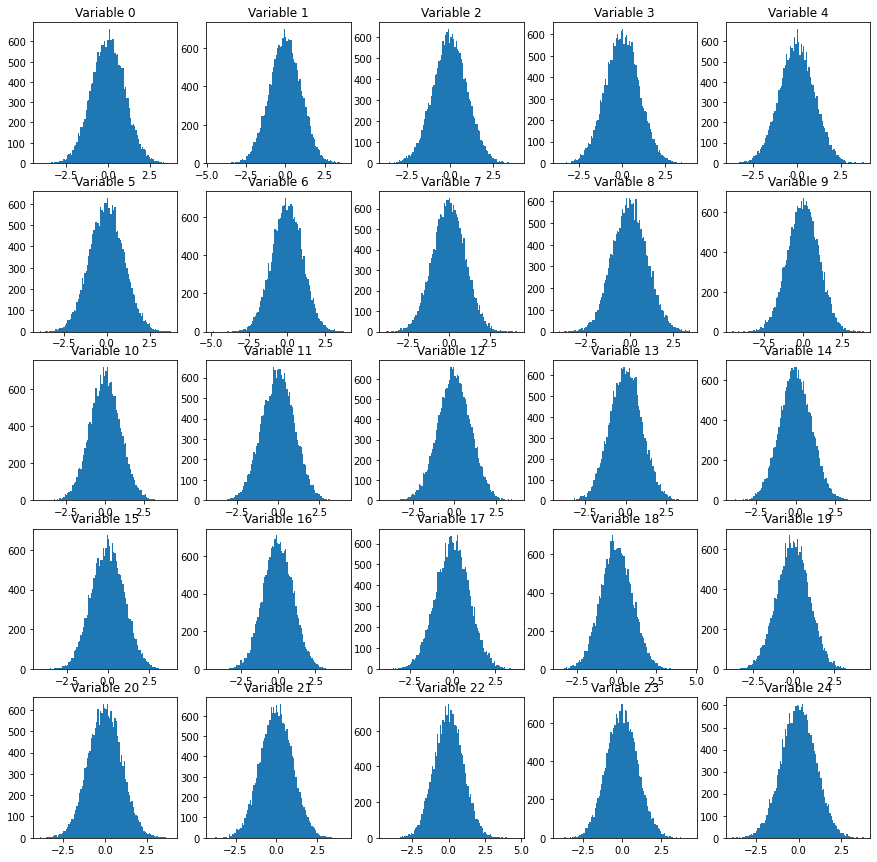

In [ ]:
plt.figure(figsize=(15,15))
for i in range(5):
    for j in range(5):
        plt.subplot(5,5,5*i+j+1)
        plt.hist(test[str(5*i+j)],bins=100)
        plt.title('Variable '+str(5*i+j))
plt.show()

#### メモ
- 250 個の訓練データで target=1 を黄色、target=0を青でとしてから 33・65 の変数だけプロットすると、データが分離できるように見える
- 300変数全てに対するlogreg で確認できる
- 33・65 だけ選んだのはなぜかというのが質問されていて回答もある
    - Lasso・RFE など特徴量選択をがんばると 33 と 65 が大事なことがわかる
    - logreg から `u1` ベクトルを使って 33 と 65 を見つけたらしい
    - `u1`は300要素持っている
        - 絶対値を降順ソートすると、33が最大、65がその次だった

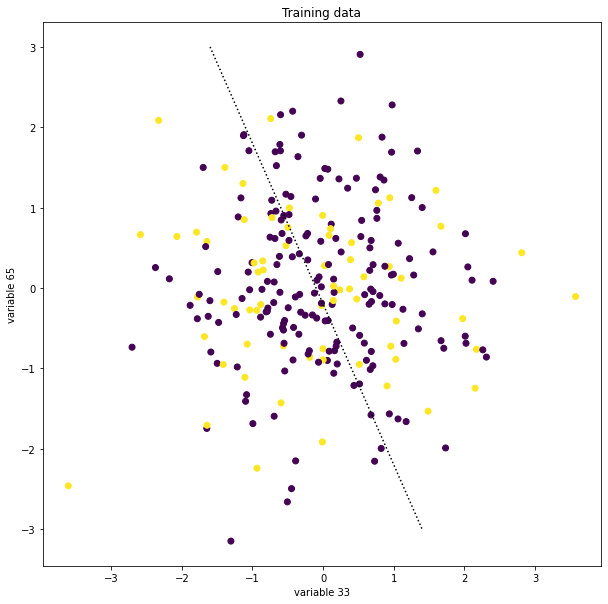

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(train['33'],train['65'],c=train['target'])
plt.plot([-1.6,1.4],[3,-3],':k')
plt.xlabel('variable 33')
plt.ylabel('variable 65')
plt.title('Training data')
plt.show()

### Logistic regression finds a hyperplane!
- logreg の係数は 300 次元空間のデータを分離する超平面（に垂直な向きの）法線
- この方向は以下の `u1` 変数
- 2 つの垂直でランダムな方向 `u2`, `u3` を作る
- `u1` と `u3` で作られた平面上に全ての点を射影する
- `u2` 方向にぐりぐり回す動画を作る

The coefficients to logistic regression are the normal of (perpendicular direction to) the hyperplane that separates the data in 300 dimensional space. This direction is variable u1 below. Next we create two random perpendicular directions u2 and u3. Thus if we project all the points onto the plane created by u1 and u3 we will see if the train data is separable. Next we can rotate through the direction u2 and view an animation.

In [ ]:
# FIND NORMAL TO HYPERPLANE
clf = LogisticRegression(solver='liblinear',penalty='l2',C=0.1,class_weight='balanced')
clf.fit(train.iloc[:,2:],train['target'])
u1 = clf.coef_[0]
u1 = u1/np.sqrt(u1.dot(u1))

In [ ]:
# CREATE RANDOM DIRECTION PERPENDICULAR TO U1
u2 = np.random.normal(0,1,300)
u2 = u2 - u1.dot(u2)*u1
u2 = u2/np.sqrt(u2.dot(u2))

In [ ]:
# CREATE RANDOM DIRECTION PERPENDICULAR TO U1 AND U2
u3 = np.random.normal(0,1,300)
u3 = u3 - u1.dot(u3)*u1 - u2.dot(u3)*u2
u3 = u3/np.sqrt(u3.dot(u3))

### Create an animation

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


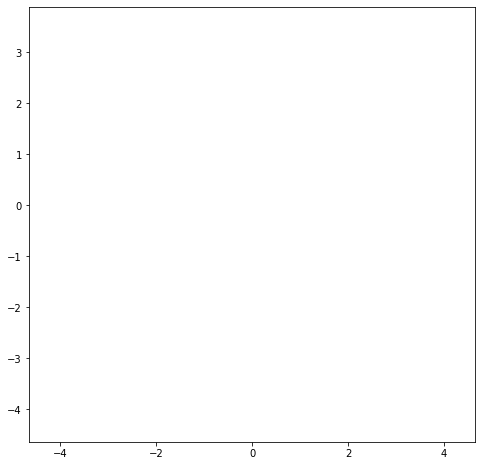

In [ ]:
# CREATE AN ANIMATION
images = []
steps = 60
fig = plt.figure(figsize=(8,8))
for k in range(steps):
    
    # CALCULATE NEW ANGLE OF ROTATION
    angR = k*(2*np.pi/steps)
    angD = round(k*(360/steps),0)
    u4 = np.cos(angR)*u1 + np.sin(angR)*u2
    u = np.concatenate([u4,u3]).reshape((2,300))
    
    # PROJECT TRAIN AND TEST ONTO U3,U4 PLANE
    p = u.dot(train.iloc[:,2:].values.transpose())
    p2 = u.dot(test.iloc[:,1:].values.transpose())

    # PLOT TEST DATA
    img1 = plt.scatter(p2[0,:],p2[1,:],c='gray')
    
    # PLOT TRAIN DATA (KEEP CORRECT COLOR IN FRONT)
    idx0 = train[ train['target']==0 ].index
    idx1 = train[ train['target']==1 ].index
    if angD<180:
        img2 = plt.scatter(p[0,idx1],p[1,idx1],c='yellow')
        img3 = plt.scatter(p[0,idx0],p[1,idx0],c='blue')
    else:
        img2 = plt.scatter(p[0,idx0],p[1,idx0],c='blue')
        img3 = plt.scatter(p[0,idx1],p[1,idx1],c='yellow')
        
    # ANNOTATE AND ADD TO MOVIE
    img4 = plt.text(1.5,-3.5,'Angle = '+str(angD)+' degrees')
    images.append([img1, img2, img3, img4])
    
# SAVE MOVIE TO FILE
ani = ArtistAnimation(fig, images)
ani.save('data.gif', writer='pillow', fps=15) # imagemagick から pillow に修正

#### 画像
<img src="https://www.kaggleusercontent.com/kf/13333323/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..8FSqbqrpKI9vDWzRTZKhcw.BRqwJ53whJ8bhXj_X8sIuJbyiG9ecr5ZcDqv0oT3F0t9zqQME4SyTdDSNkWp1wpifl0JGGIA2A3dSNnHijcdIFBOk3MZABK4eIQHt1Z_gQmd27JeFu9EfQv8tHMjmKPS9Zk0gWIOeKHC_okXaZvdBghqhkt5icUudKkPtP0riPs107l_RiANCUT2BHRnHCGyAROs2EyYIWgnrYQ58LZVEOKNMHB-I58JdYqX-GIRQZSQW-PVzjE9uXdwCenOIs3j3iBRE57QqoL6FIEghKU3BkoPdsaiprYuj7qXkCAfPI7tkghUfI61m6sTE9jjI7gc7VS8OLf9spo6BnYW70fC7TEmf3DyEkuqL46e8bryjKBJczFkQR93CHr3MR1bF2bam-zNLBhJsd1iSGuZzeIdIkI0j0FRuTccLhLqQE-wIPRrn5BPfl4npNrm2sRfEaMf1D5Mw3nIonUgHscU_lHV5tkjQ_EnlcOYnNFbg_W3KQ-0BTO10LZg8x-jeD-D0T3XO3PX5fdaaN7-lXQp7ejI2dtSJX7PH4r5qK7W9-iKWtOyYJ2ro0yGqbzME2typn2O0awU-ZAnsTnm2vnySTHrFz-smmuXzxRluVVHmXFgSzPINLbPdRzQfByzLg3YdvyC.t98gIDyBaMwpBApVMC3LpQ/data.gif">